# Error scripts

## Info

Types of errors:
1. Relabelling (misclassification) (top1)
2. Size alternation (top2)
3. Remove/delete label (top3)  +
4. Shift bounding box (top4)   +
4. Spawn new bounding box (top4)

How this it works:

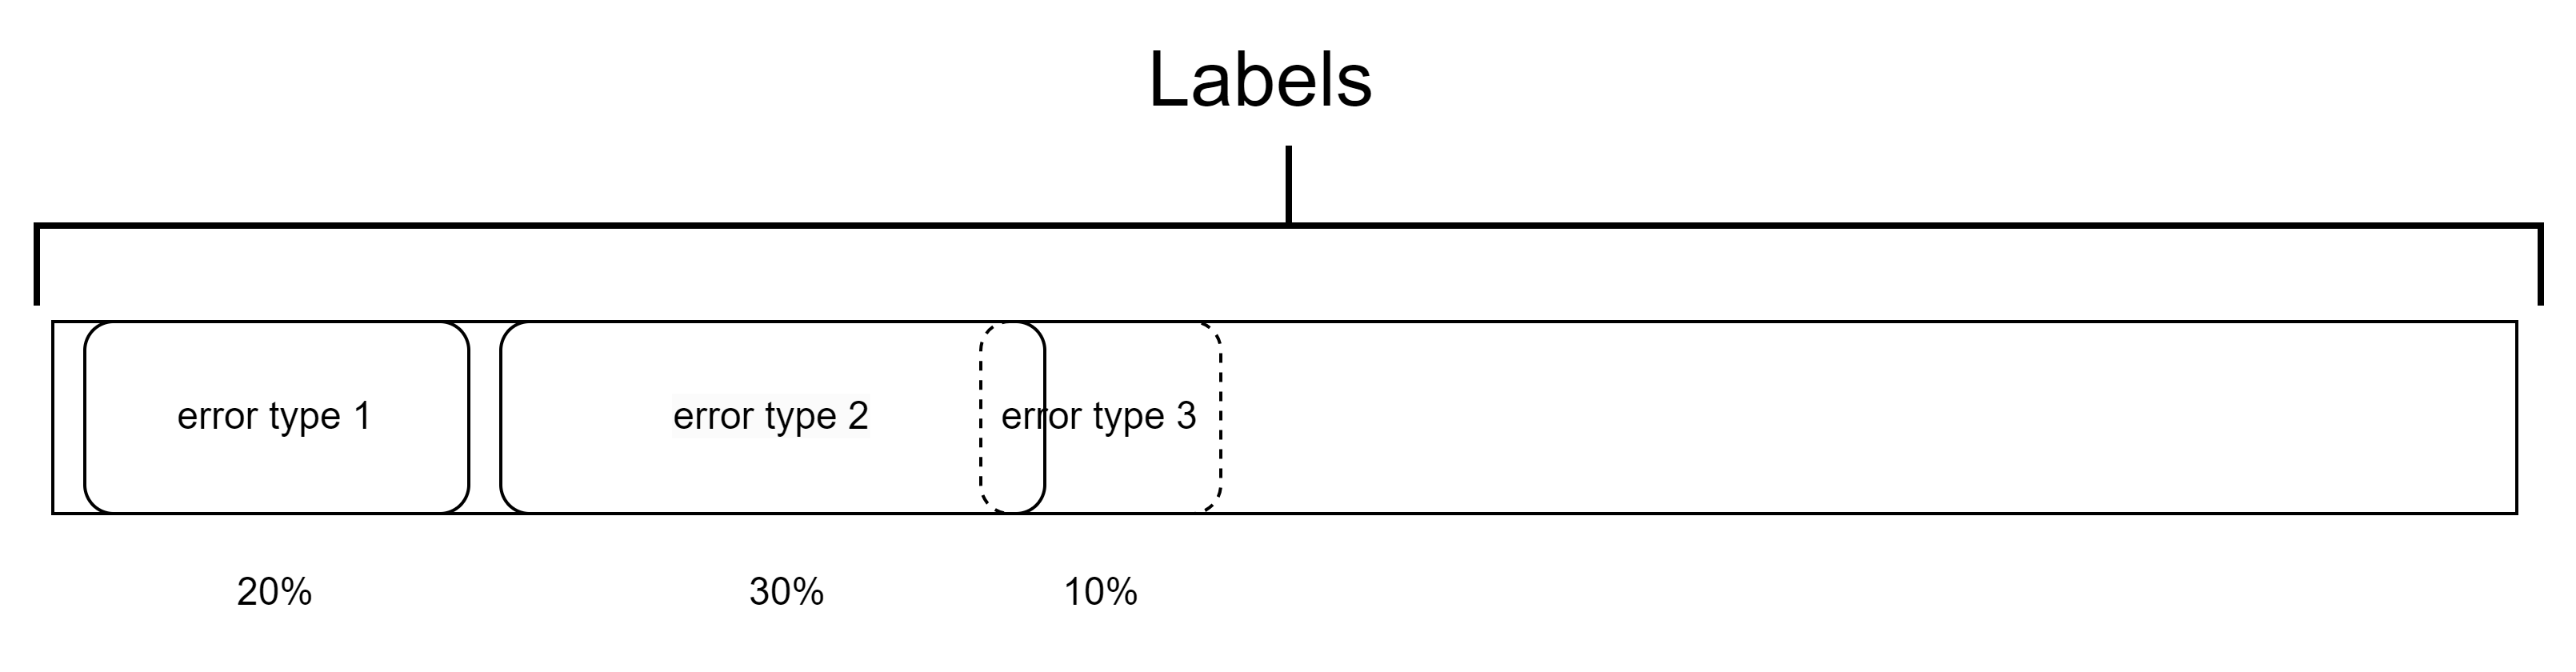


__Take into account__!  
Distibution of errors within dataset or within one error type could be improved depending on:
-  categories (how many errors for car we want, what are most common errors for car should be, etc.)
-  original sizes (shift box by amount of pixels based on original size, distribute errors between large and small bounding boxes,
  the shift or size alternation depends on the original size)

## Setup

In [ ]:
import os
import random

import cv2
from PIL import Image, ImageDraw, ImageFont
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

## Load data

In [ ]:
images_folder_val = "100k_images_val/val"
json_labels_val = "bdd100k_det_20_labels_trainval/det_20/det_val.json"

In [ ]:
with open(json_labels_val, 'r') as file:
    data_val = json.load(file)

## Clean data

In [ ]:
categories_to_del = ["train", "trailer", "other person"]
for image_data in dataset:
    image_data['labels'] = [label for label in image_data['labels'] if label['category'] not in categories_to_del]

## Visualizations

In [ ]:
color_map = {
    "pedestrian": "blue",
    "rider": "green",
    "car": "red",
    "truck": "sienna",
    "bus": "cyan",
    "other vehicle": "pink",
    "motorcycle": "yellow",
    "bicycle": "orange",
    "traffic light": "lime",
    "traffic sign": "magenta"
}

def draw_bounding_boxes(image_path, labels):
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        for label in labels:
            category = label['category']
            color = color_map.get(category, "white")  # Default to white if category not found
            box = label['box2d']
            draw.rectangle([box['x1'], box['y1'], box['x2'], box['y2']], outline=color, width=2)
        return img

def plot_image_w_labels(image_folder, image_name, labels):
    image_path = os.path.join(image_folder, image_name)
    img = draw_bounding_boxes(image_path, labels)
    plt.figure(figsize=(15, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {image_name}") 
    plt.show()

## Helper functions

In [ ]:
def find_image_info_by_label_id(dataset, label_id):
    """
    Finds the image information and all labels for a given label ID in the dataset.

    :param dataset: A list of dictionaries, where each dictionary contains information about an image and its labels.
    :param label_id: The label ID to search for in the dataset.
    :return: A dictionary containing the image information and labels if the label ID is found, otherwise None.
    """
    for image in dataset:
        for label in image['labels']:
            if label['id'] == label_id:
                return image
    return None

In [ ]:
def find_image_info_by_name(dataset, image_name):
    """
    Finds the image information by its name in the dataset.

    :param dataset: A list of dictionaries, where each dictionary contains information about an image.
    :param image_name: The name of the image to search for in the dataset.
    :return: A dictionary containing the image information if the name is found, otherwise None.
    """
    for image in dataset:
        if image['name'] == image_name:
            return image
    return None

In [ ]:
def get_all_label_ids(dataset):
    label_ids = []
    for entry in dataset:
        for label in entry['labels']:
            label_ids.append(label['id'])
    return label_ids

In [ ]:
def get_label_ids_by_min_area(dataset, min_area=200):
    """
    Filters and returns label IDs based on a minimum bounding box area.
    
    Parameters:
    - dataset: A list of dictionaries, each containing 'labels' with bounding box data.
    - min_area (int): The minimum area threshold for the bounding boxes.
    
    Returns:
    - list: A list of label IDs that have a bounding box area greater than or equal to the minimum area.
    """
    eligible_label_ids = []

    # Iterate over the dataset to check each label
    for image_info in dataset:
        for label in image_info['labels']:
            x1, y1, x2, y2 = label['box2d']['x1'], label['box2d']['y1'], label['box2d']['x2'], label['box2d']['y2']
            width = x2 - x1
            height = y2 - y1
            area = width * height
            if area >= min_area:
                eligible_label_ids.append(label['id'])

    return eligible_label_ids

In [ ]:
def clamp(value, min_value, max_value):
    '''
    Ensures bounding box is in image frame.
    '''
    return max(min_value, min(value, max_value))

## Error functions

### Misclassification

Possible approach in the future?

Dictionary defining possible misclassification probabilities for each category based on similarity and likelihood of confusion.  
_Example: `bicycle` could be misclassified as `motorcycle` with 40% probability_

In [ ]:
misclassification_dict = {
    'bicycle': {'motorcycle': 0.40, 'pedestrian': 0.30, 'rider': 0.30,},
    
    'bus': {'truck': 0.40, 'car': 0.30, 'other vehicle': 0.30},
    
    'car': {'truck': 0.35, 'bus': 0.35, 'traffic light': 0.05, 'other person': 0.25},

    'motorcycle': {'bicycle': 0.50, 'rider': 0.50}, 
    
    'other vehicle': {'truck': 0.25, 'trailer': 0.25, 'bus': 0.25, 'train': 0.25},

    'pedestrian': {'other person': 0.70, 'rider': 0.30},
    
    'rider': {'bicycle': 0.50, 'motorcycle': 0.50},
    
    'traffic light': {'traffic sign': 0.80, 'car': 0.20},
    
    'traffic sign': {'traffic light': 0.80, 'other vehicle': 0.20},
    
    'truck': {'car': 0.40, 'trailer': 0.30, 'bus': 0.30}
}


In [ ]:
def misclassificate_label(label_info, misclassification_dict):
    """
    Misclassify label based on a dictionary of misclassification probabilities.

    :param misclassification_dict: Dictionary mapping original categories to possible misclassifications and their probabilities.
    :return: None; labels are modified in place.
    """
    
    original_category = label_info['category']
    if original_category in misclassification_dict:
        categories, weights = zip(*misclassification_dict[original_category].items())
        label_info['category'] = random.choices(categories, weights=weights, k=1)[0]

Now back to actual solution

In [ ]:
categories = {
       'bicycle',
       'bus',
       'car',
       'motorcycle',
       'other vehicle',
       'pedestrian',
       'rider',
       'traffic light',
       'traffic sign',
       'truck'
    }

In [ ]:
def misclassificate_labels_in_dataset(dataset, categories, fraction=0.1):
    """
    Randomly applies shifting errors to a fraction of the labels in the dataset.

    :param labels: The entire dataset of labels.
    :param fraction: Fraction of labels to modify.
    :return: The dataset with updated labels.
    """
    print("Starting to Misclassify labels...")
    
    all_label_ids = get_all_label_ids(dataset)
    num_to_modify = int(len(all_label_ids) * fraction)
    selected_label_ids = random.sample(all_label_ids, num_to_modify)
    selected_label_ids.sort(key=float)

    total_labels = len(selected_label_ids)
    report_interval = total_labels // 10  # Determine when to report progress

    # Initialize a counter for reporting progress
    counter = 0

    # Iterate over the dataset and modify only selected labels
    for image in dataset:
        labels = image['labels']
        for label in labels:
            if label['id'] in selected_label_ids:
                original_category = label['category']
                possible_categories = categories - {original_category}  # Remove the original category from the possible choices  # Remove the original category from the possible choices
                label['category'] = random.choice(list(possible_categories))
                
                # Increment and report progress at intervals
                counter += 1
                if counter % report_interval == 0:
                    progress_percentage = (counter / total_labels) * 100
                    print(f"Progress: {progress_percentage:.1f}%")

    return selected_label_ids

#### Works well? Let's check.

In [ ]:
modified_dataset = deepcopy(data_val) # for comparison

In [ ]:
modified_ids = misclassificate_labels_in_dataset(modified_dataset, categories)

In [ ]:
mod_id = 6

old_image_info = find_image_info_by_label_id(data_val, modified_ids[mod_id])
old_image_labels = old_image_info["labels"]

new_image_info = find_image_info_by_label_id(modified_dataset, modified_ids[mod_id])
new_image_labels = new_image_info["labels"]

In [ ]:
modified_ids[mod_id]

In [ ]:
# BEFORE
for label in old_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)
        
# AFTER
for label in new_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)

### Size Alternation

In [ ]:
def alter_bounding_box(label_info, min_factor=0.22, max_factor=0.3):
    """
    Modifies one of the four sides of the bounding box in place, either increasing or decreasing it
    by a random factor between the given minimum and maximum percentages.

    Parameters:
    - label_info (dict): A label dictionary with bounding box data.
    - min_factor (float): Minimum percentage change factor.
    - max_factor (float): Maximum percentage change factor.
    """
    img_width, img_height = 1280, 720  # Image dimensions, specific to BDD100K

    # Extract coordinates
    x1, y1, x2, y2 = label_info['box2d']['x1'], label_info['box2d']['y1'], label_info['box2d']['x2'], label_info['box2d']['y2']

    # Decide randomly whether to change width or height
    if random.choice(['width', 'height']) == 'width':
        # Calculate current width and select a random change factor
        width = x2 - x1
        width_change = random.uniform(min_factor, max_factor) * width
        width_change *= -1 if random.choice([True, False]) else 1

        # Randomly apply width change to either the left or right side
        if random.choice(['left', 'right']) == 'left':
            label_info['box2d']['x1'] = clamp(x1 + width_change, 0, x2)
        else:
            label_info['box2d']['x2'] = clamp(x2 - width_change, x1, img_width)
    else:
        # Calculate current height and select a random change factor
        height = y2 - y1
        height_change = random.uniform(min_factor, max_factor) * height
        height_change *= -1 if random.choice([True, False]) else 1

        # Randomly apply height change to either the top or bottom side
        if random.choice(['top', 'bottom']) == 'top':
            label_info['box2d']['y1'] = clamp(y1 + height_change, 0, y2)
        else:
            label_info['box2d']['y2'] = clamp(y2 - height_change, y1, img_height)

In [ ]:
def alternate_size_in_dataset(dataset, fraction=0.1, min_area=400,
                              min_factor=0.2, max_factor=0.3):
    """
    Randomly alters the size of a fraction of the bounding boxes in the dataset that meet a minimum area requirement.
    This alteration involves randomly increasing or decreasing the dimensions of the bounding boxes.

    :param dataset: List of dictionaries, each representing an image with labels.
    :param fraction: Fraction of eligible labels to modify.
    :param min_area: Minimum area of the bounding box to include a label for potential modification.
    :param min_factor: Minimum percentage by which the bounding box dimensions will be changed.
    :param max_factor: Maximum percentage by which the bounding box dimensions will be changed.
    :return: None; modifies the dataset in place.
    """
    
    print("Starting to Alternate labels sizes...")
    
    satisfactory_label_ids = get_label_ids_by_min_area(dataset, min_area)
    num_to_modify = int(len(satisfactory_label_ids) * fraction)
    selected_label_ids = random.sample(satisfactory_label_ids, num_to_modify)
    selected_label_ids.sort(key=float)

    # Total labels in the dataset for progress calculation
    total_labels = len(selected_label_ids)
    labels_processed = 0

    # Iterate through each image in the dataset
    for image in dataset:
        labels = image['labels']
        # Iterate through each label in the current image
        for label in labels:
            if label['id'] in selected_label_ids:
                # Modify the label in place
                alter_bounding_box(label, min_factor, max_factor)
            
                # Report progress every 10% (adjustable)
                labels_processed += 1
                if labels_processed % (total_labels // 10) == 0:
                    progress_percentage = (labels_processed / total_labels) * 100
                    print(f"Progress: {progress_percentage:.1f}%")
                
    return selected_label_ids

#### Works well? Let's check.

In [ ]:
modified_dataset = deepcopy(data_val) # for comparison

In [ ]:
modified_ids = alternate_size_in_dataset(modified_dataset)

In [ ]:
mod_id = 1

old_image_info = find_image_info_by_label_id(data_val, modified_ids[mod_id])
old_image_labels = old_image_info["labels"]

new_image_info = find_image_info_by_label_id(modified_dataset, modified_ids[mod_id])
new_image_labels = new_image_info["labels"]

image_name = new_image_info["name"]

In [ ]:
modified_ids[mod_id]

In [ ]:
# BEFORE
for label in old_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)
        
# AFTER
for label in new_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)

In [ ]:
# BEFORE
plot_image_w_labels(images_folder_val, image_name, old_image_labels)

# AFTER
plot_image_w_labels(images_folder_val, image_name, new_image_labels)

#### TESTING ZONE

##### For single image

In [ ]:
testing_dataset = deepcopy(data_val)

In [ ]:
image_info = testing_dataset[3]
bigger_labels_ids = get_label_ids_by_min_area([image_info], 400)
name = image_info["name"]
len(bigger_labels_ids)

In [ ]:
modified_img_labels = deepcopy(image_info["labels"])
before_labels = deepcopy(modified_img_labels)
# BEFORE
for label in before_labels:
    if label["id"] == bigger_labels_ids[13]:
        label_info = label
print(label_info)

# AFTER
for label in modified_img_labels:
    if label["id"] == bigger_labels_ids[13]:
        label_info = label
alter_bounding_box(label_info)
print(label_info)

In [ ]:
# BEFORE
plot_image_w_labels(images_folder_val, name, before_labels)

# AFTER
plot_image_w_labels(images_folder_val, name, modified_img_labels)

### Remove label

In [ ]:
def remove_random_labels_in_dataset(dataset, fraction=0.1):
    """
    Randomly removes a fraction of the labels from the dataset.

    :param dataset: The dataset containing all label information.
    :param fraction: Fraction of labels to remove.
    :return: The dataset with labels removed.
    """
    print("Starting to Remove labels...")
    
    # Gather all label IDs in the dataset
    all_label_ids = get_all_label_ids(dataset)
    num_to_modify = int(len(all_label_ids) * fraction)
    selected_label_ids = random.sample(all_label_ids, num_to_modify)
    selected_label_ids.sort(key=float)

    total_entries = len(dataset)
    progress_checkpoint = total_entries // 10

    # Remove selected labels from each entry in the dataset directly
    for index, entry in enumerate(dataset):
        entry["labels"] = [label for label in entry["labels"] if label["id"] not in selected_label_ids]

        # Print progress every 10%
        if (index + 1) % progress_checkpoint == 0 or index + 1 == total_entries:
            progress = (index + 1) / total_entries * 100
            print(f"Progress: {progress:.1f}%")

    return selected_label_ids

#### Works well? Let's check.

In [ ]:
modified_dataset = deepcopy(data_val) # for comparison

In [ ]:
modified_ids = remove_random_labels_in_dataset(modified_dataset)

In [ ]:
mod_id = 0

old_image_info = find_image_info_by_label_id(data_val, modified_ids[mod_id])
old_image_labels = old_image_info["labels"]

image_name = old_image_info["name"]

new_image_info = find_image_info_by_name(modified_dataset, image_name)
new_image_labels = new_image_info["labels"]

In [ ]:
# ORIGINAL CATEGORY of the label
for label in old_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(f"Original Category: {label["category"]}")

In [ ]:
# BEFORE
for label in old_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)
        break
        
# AFTER
for label in new_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)
        print("ERROR!!! Label has been found!")
print(f"Label with ID = {modified_ids[mod_id]} has been removed succesfully.")

In [ ]:
# BEFORE
plot_image_w_labels(images_folder_val, image_name, old_image_labels)

# AFTER
plot_image_w_labels(images_folder_val, image_name, new_image_labels)

### Shift

In [ ]:
def shift_bounding_box(label_info, min_factor=0.15, max_factor=0.2):
    """
    Shifts the entire bounding box diagonally based on a percentage of its own dimensions,
    ensuring that each shift is at least a minimum percentage and no more than a maximum percentage of its size.

    Parameters:
    - label_info (dict): A label dictionary with bounding box data.
    - min_factor (float): Minimum percentage of the bounding box dimensions to shift.
    - max_factor (float): Maximum percentage of the bounding box dimensions to shift.
    """
    img_width, img_height = 1280, 720  # Image dimensions, specific to BDD100K

    
    # Extract bounding box coordinates
    x1 = label_info['box2d']['x1']
    y1 = label_info['box2d']['y1']
    x2 = label_info['box2d']['x2']
    y2 = label_info['box2d']['y2']
    
    # Calculate width and height of the bounding box
    width = x2 - x1
    height = y2 - y1

    # Calculate random shift factors for x and y based on the bounding box dimensions
    x_shift = random.uniform(min_factor, max_factor) * width * random.choice([-1, 1])
    y_shift = random.uniform(min_factor, max_factor) * height * random.choice([-1, 1])

    # Apply the shifts directly to the bounding box coordinates
    label_info['box2d']['x1'] += x_shift
    label_info['box2d']['y1'] += y_shift
    label_info['box2d']['x2'] += x_shift
    label_info['box2d']['y2'] += y_shift

    # Apply the shifts and use clamp to ensure coordinates stay within the image frame
    label_info['box2d']['x1'] = clamp(label_info['box2d']['x1'], 0, img_width)
    label_info['box2d']['y1'] = clamp(label_info['box2d']['y1'], 0, img_height)
    label_info['box2d']['x2'] = clamp(label_info['box2d']['x2'], 0, img_width)
    label_info['box2d']['y2'] = clamp(label_info['box2d']['y2'], 0, img_height)


In [ ]:
def shift_bounding_boxes_in_dataset(dataset, fraction=0.1, min_area=400, min_factor=0.15, max_factor=0.2):
    """
    Modifies the bounding box by shifting its coordinates diagonally.

    :param label_info: A dictionary containing the bounding box details.
    :param min_factor: Minimum percentage of the bounding box dimensions to shift.
    :param max_factor: Maximum percentage of the bounding box dimensions to shift.
    :return: None; modifies the label_info dictionary in place.
    """
    print("Starting to Shift labels...")
    
    satisfactory_label_ids = get_label_ids_by_min_area(dataset, min_area=min_area)
    num_to_modify = int(len(satisfactory_label_ids) * fraction)
    selected_label_ids = random.sample(satisfactory_label_ids, num_to_modify)
    selected_label_ids.sort(key=float)

    # Total labels in the dataset for progress calculation
    total_labels = len(selected_label_ids)
    labels_processed = 0

    # Iterate through each image in the dataset
    for image in dataset:
        labels = image['labels']
        # Iterate through each label in the current image
        for label in labels:
            if label['id'] in selected_label_ids:
                # Modify the label in place
                shift_bounding_box(label, min_factor, max_factor)
            
                # Report progress every 10% (adjustable)
                labels_processed += 1
                if labels_processed % (total_labels // 10) == 0:
                    progress_percentage = (labels_processed / total_labels) * 100
                    print(f"Progress: {progress_percentage:.1f}%")
    
    return selected_label_ids

#### Works well? Let's check.

In [ ]:
modified_dataset = deepcopy(data_val) # for comparison

In [ ]:
modified_ids = shift_bounding_boxes_in_dataset(modified_dataset)

In [ ]:
mod_id = 3

old_image_info = find_image_info_by_label_id(data_val, modified_ids[mod_id])
old_image_labels = old_image_info["labels"]

new_image_info = find_image_info_by_label_id(modified_dataset, modified_ids[mod_id])
new_image_labels = new_image_info["labels"]

image_name = new_image_info["name"]

In [ ]:
modified_ids[mod_id]

In [ ]:
# BEFORE
for label in old_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)
        
# AFTER
for label in new_image_labels:
    if label["id"] == modified_ids[mod_id]:
        print(label)

In [ ]:
# BEFORE
plot_image_w_labels(images_folder_val, image_name, old_image_labels)

# AFTER
plot_image_w_labels(images_folder_val, image_name, new_image_labels)

#### TESTING ZONE

##### For single image

In [ ]:
testing_dataset = deepcopy(data_val)

In [ ]:
image_info = testing_dataset[3]
name = image_info["name"]
bigger_labels_ids = get_label_ids_by_min_area([image_info], 400)
len(bigger_labels_ids)

In [ ]:
modified_img_labels = deepcopy(image_info["labels"])
before_labels = deepcopy(modified_img_labels)


# BEFORE
for label in before_labels:
    if label["id"] == bigger_labels_ids[0]: #id 13
        label_info = label
print(label_info)

# AFTER
for label in modified_img_labels:
    if label["id"] == bigger_labels_ids[0]:
        label_info = label
shift_bounding_box(label_info)
print(label_info)

In [ ]:
# AFTER
plot_image_w_labels(images_folder_val, name, modified_img_labels)
# BEFORE
plot_image_w_labels(images_folder_val, name, before_labels)

## CREATE AN EPL DATASET

In [ ]:
with open(json_labels_val, 'r') as file:
    data_val = json.load(file)

In [ ]:
categories_to_del = ["train", "trailer", "other person"]
for image_data in dataset:
    image_data['labels'] = [label for label in image_data['labels'] if label['category'] not in categories_to_del]

In [ ]:
error_dataset = deepcopy(data_val)

In [ ]:
error_ids_dict = {
    "misclassification_err": [],
    "size_alternation_err": [],
    "remove_label_err": [],
    "shifting_err": [],
}

In [ ]:
error_ids_dict["remove_label_err"] = remove_random_labels_in_dataset(dataset=error_dataset, fraction=0.1)
error_ids_dict["size_alternation_err"] = alternate_size_in_dataset(dataset=error_dataset, fraction=0.15)
error_ids_dict["shifting_err"] = shift_bounding_boxes_in_dataset(dataset=error_dataset, fraction=0.07)
error_ids_dict["misclassification_err"] = misclassificate_labels_in_dataset(dataset=error_dataset, categories=categories, fraction=0.2)